# MKP pro Stokesovy a Navierovy-Stokesovy rovnice

Uvažujme úlohu proudění tekutiny v rozvětveném kanálu s těmito parametry:
* Rychlost proudění na vstupu $\Gamma_2$ má kvadratický profil s maximem 1 $m/s$.
* Na stěnách $\Gamma_1$ tekutina ulpívá (nulová rychlost).
* Na výtoku $\Gamma_3\cup\Gamma_4$ je předepsána podmínka "do-nothing".
* Viskozita je $10^{-3}$ $Pa.s$, hustota $1$ $kg/m^3$.

![alt text](img/vessel.png "Geometrie kanálu.")

In [1]:
# Společné definice

from dolfin import *
from matplotlib import pyplot as plt

# Potlačení zpráv typu "Solving linear variational problem."
set_log_level(LogLevel.WARNING)

# Vytvoření sítě elementů
mesh = Mesh("vessel.xml")
bc_regions = MeshFunction("size_t", mesh, "vessel_facet_region.xml")
ds = Measure("ds")(subdomain_data=bc_regions)

# Definice parametrů modelu
mu = Constant(1e-3) # viskozita
rho = Constant(1e0) # hustota
f  = Constant((0,0)) # objemová síla
v_in = Expression(("100*x[1]*(0.2-x[1])","0"), degree=2) # vstupní rychlost
v_wall = Constant((0,0)) # rychlost u stěny

# Prostory funkcí (poslední parametr udává stupeň polynomu v konečném prvku)
FE_v = VectorElement('CG', mesh.ufl_cell(), 2)
FE_p = FiniteElement('CG', mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, FE_v*FE_p)

# Okrajové podmínky
bc_inflow = DirichletBC(W.sub(0), v_in, bc_regions, 2)
bc_wall = DirichletBC(W.sub(0), v_wall, bc_regions, 1)

# Numerické parametry
alpha = 1 # parametr tlumení v Picardově metodě (1 = aktuální iterace, 0 = předchozí iterace)
res_tol = 1e-9 # relativní tolerance pro rozdíl řešení ve dvou iteracích
max_it = 50 # limit počtu iterací

# pomocná funkce
def neg_part(x):
    return (x-abs(x))/Constant(2)

# Stokesovy rovnice
Nejprve úlohu vyřešíme jako lineární Stokesův problém.

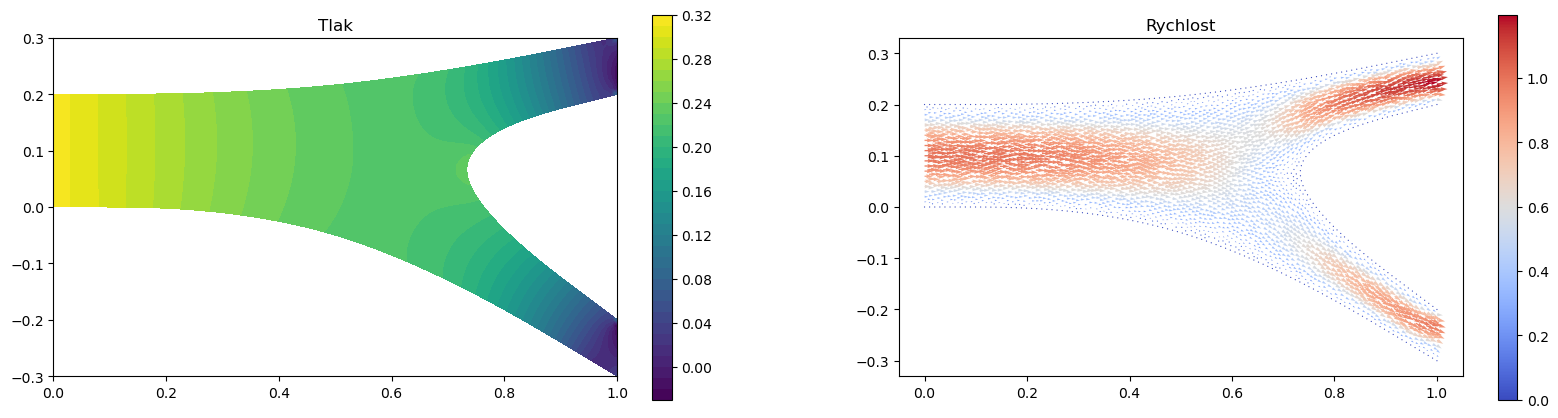

In [2]:
# Variační problém
(v,p) = TrialFunctions(W)
(w,q) = TestFunctions(W)
vp0 = Function(W) # předchozí iterace
z = vp0.sub(0)
n = FacetNormal(mesh)
a = (
     2*mu*inner(sym(grad(v)),sym(grad(w)))*dx
     - p*div(w)*dx + q*div(v)*dx
    )
l = rho*dot(f,w)*dx

# Řešení
vp = Function(W)
solve(a == l, vp, [bc_inflow, bc_wall])

# Zobrazení
(v_stokes,p_stokes) = vp.split()
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
c = plot(p_stokes, title='Tlak')
plt.colorbar(c, shrink=0.5)
plt.subplot(1,2,2)
c = plot(v_stokes, title='Rychlost')
c.set_cmap('coolwarm')
plt.colorbar(c, shrink=0.5)
plt.show()

# Navierovy-Stokesovy rovnice - Picardova metoda
Nyní budeme řešit problém jako Navierovy-Stokesovy rovnice a linearizovat pomocí Picardovy metody. Podmínka "do-nothing" je upravena dle teorie na tvar zamezující zpětné proudění. Všimněte si rozdílů oproti řešení Stokesova problému. K dosažení požadované tolerance se metoda blíží relativně pomalu, v závislosti na poměru vstupních parametrů (viskozita, hustota, síla).

it norm         abs-diff     rel-diff
 1 7.281017e+01 7.281017e+01 1.000000e+00
 2 7.360301e+01 1.514728e+01 2.057971e-01
 3 7.492795e+01 7.945689e+00 1.060444e-01
 4 7.594273e+01 5.433712e+00 7.155012e-02
 5 7.603921e+01 1.509193e+00 1.984756e-02
 6 7.577913e+01 1.354630e+00 1.787603e-02
 7 7.565193e+01 8.074189e-01 1.067281e-02
 8 7.566488e+01 3.429790e-01 4.532869e-03
 9 7.570613e+01 3.046074e-01 4.023549e-03
10 7.572209e+01 1.614859e-01 2.132613e-03
11 7.571800e+01 8.171549e-02 1.079208e-03
12 7.571167e+01 5.236126e-02 6.915878e-04
13 7.570981e+01 2.335397e-02 3.084669e-04
14 7.571063e+01 1.274089e-02 1.682840e-04
15 7.571145e+01 7.696142e-03 1.016510e-04
16 7.571156e+01 3.353504e-03 4.429316e-05
17 7.571138e+01 2.265631e-03 2.992457e-05
18 7.571126e+01 1.414272e-03 1.867980e-05
19 7.571128e+01 7.832980e-04 1.034586e-05
20 7.571132e+01 5.072103e-04 6.699267e-06
21 7.571134e+01 2.651385e-04 3.501966e-06
22 7.571133e+01 1.492790e-04 1.971686e-06
23 7.571132e+01 1.084314e-04 1.432168e

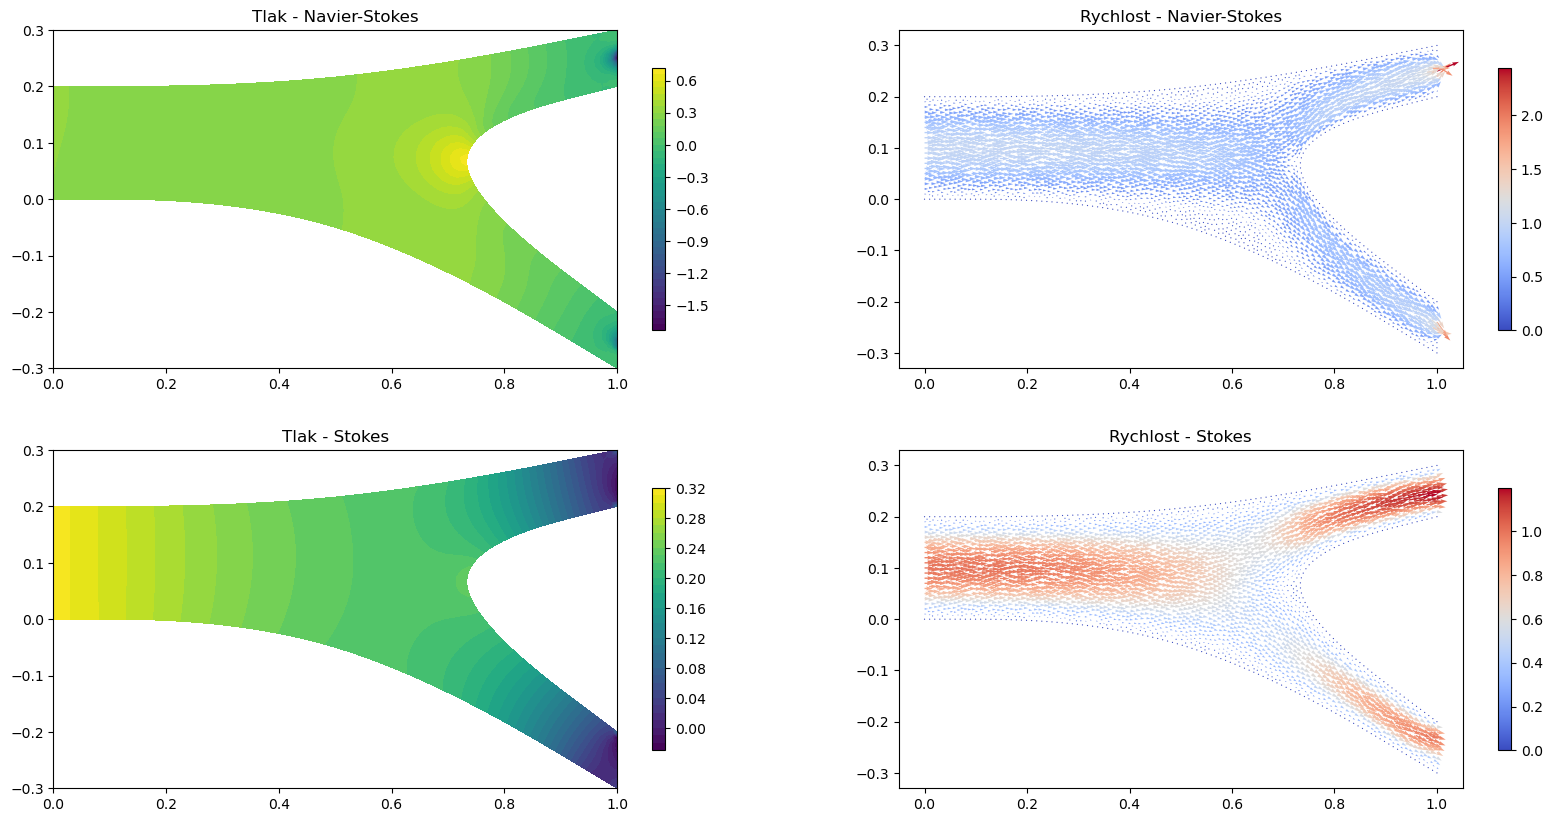

In [5]:
# Variační problém
(v,p) = TrialFunctions(W)
(w,q) = TestFunctions(W)
vp0 = Function(W) # předchozí iterace
z = vp0.sub(0)
n = FacetNormal(mesh)
a = (
     2*mu*inner(sym(grad(v)),sym(grad(w)))*dx
     + 0.5*rho*(inner(grad(v),outer(w,z))-inner(grad(w),outer(v,z)))*dx
     - p*div(w)*dx + q*div(v)*dx
     + 0.5*rho*neg_part(dot(z,n))*dot(v,w)*ds(3)
     + 0.5*rho*neg_part(dot(z,n))*dot(v,w)*ds(4)
    )
l = rho*dot(f,w)*dx

# Řešení
vp = Function(W)
k = 0
print( "it norm         abs-diff     rel-diff" )
while (k == 0 or res > res_tol*vp_norm) and k < max_it:
  k = k + 1
  solve(a == l, vp, [bc_inflow, bc_wall])
  res = (vp0.vector()-vp.vector()).norm("l2") # absolutní chyba
  vp_norm = vp.vector().norm("l2") # norma řešení
  print( '{:2} {:6e} {:6e} {:6e}'.format(k, vp_norm, res, res/vp_norm) )
  vp0.vector()[:] = alpha*vp.vector() + (1-alpha)*vp0.vector()

if res > res_tol*vp_norm:
    raise Exception('Metoda nekonverguje!')

# Zobrazení
(v_picard,p_picard) = vp.split()
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
c = plot(p_picard, title='Tlak - Navier-Stokes')
plt.colorbar(c, shrink=0.75)

plt.subplot(2,2,2)
c = plot(v_picard, title='Rychlost - Navier-Stokes')
c.set_cmap('coolwarm')
plt.colorbar(c, shrink=0.75)

plt.subplot(2,2,3)
c = plot(p_stokes, title='Tlak - Stokes')
plt.colorbar(c, shrink=0.75)

plt.subplot(2,2,4)
c = plot(v_stokes, title='Rychlost - Stokes')
c.set_cmap('coolwarm')
plt.colorbar(c, shrink=0.75)
plt.show()

## Navierovy-Stokesovy rovnice - Newtonova metoda
Navierovy-Stokesovy rovnice je možné linearizovat také pomocí Newtonovy metody.
Konvergence opět závisí na poměru parametrů modelu, obecně však metoda vyžaduje výrazně méně iterací než metoda Picardova.

it norm         abs-diff     rel-diff
 1 4.618801e+00 7.263644e+01 1.572625e+01
 2 7.278314e+01 2.251589e+01 3.093559e-01
 3 7.740200e+01 1.572512e+01 2.031617e-01
 4 7.638496e+01 8.298401e+00 1.086392e-01
 5 7.613327e+01 4.139559e+00 5.437254e-02
 6 7.577755e+01 1.187500e+00 1.567086e-02
 7 7.571524e+01 1.716662e-01 2.267260e-03
 8 7.571170e+01 5.249233e-03 6.933185e-05
 9 7.571133e+01 1.278385e-04 1.688499e-06
10 7.571132e+01 3.522371e-06 4.652371e-08
11 7.571132e+01 9.545756e-08 1.260810e-09
12 7.571132e+01 2.579909e-09 3.407560e-11


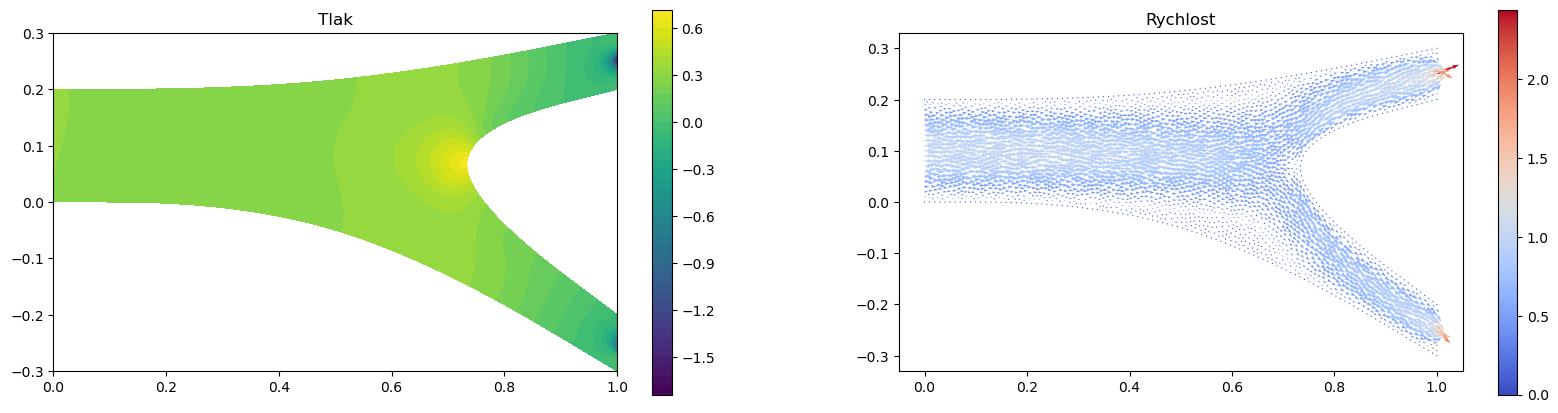

In [6]:
# Variační problém
(dv,dp) = TrialFunctions(W)
(w,q) = TestFunctions(W)
vp = Function(W) # předchozí iterace
bc_inflow.apply(vp.vector())
(vold,pold) = vp.split()
n = FacetNormal(mesh)
a = (
     2*mu*inner(sym(grad(dv)),sym(grad(w)))*dx
     + 0.5*rho*(inner(grad(dv),outer(w,vold))-inner(grad(w),outer(dv,vold)))*dx
     + 0.5*rho*(inner(grad(vold),outer(w,dv))-inner(grad(w),outer(vold,dv)))*dx
     - dp*div(w)*dx + q*div(dv)*dx
     + 0.5*rho*neg_part(dot(vold,n))*dot(dv,w)*ds(3)
     + 0.5*rho*neg_part(dot(vold,n))*dot(dv,w)*ds(4)
    )
l = (
     2*mu*inner(sym(grad(vold)),sym(grad(w)))*dx
     + 0.5*rho*(inner(grad(vold),outer(w,vold))-inner(grad(w),outer(vold,vold)))*dx
     + 0.5*rho*neg_part(dot(vold,n))*dot(vold,w)*ds(3)
     + 0.5*rho*neg_part(dot(vold,n))*dot(vold,w)*ds(4)
     - pold*div(w)*dx + q*div(vold)*dx - rho*dot(f,w)*dx
    )

# Řešení
dvp = Function(W) # přírůstky
bc_inflow_0 = DirichletBC(W.sub(0), Constant((0,0)), bc_regions, 2)
k = 0
print( "it norm         abs-diff     rel-diff" )
while (k == 0 or res > res_tol*vp_norm) and k < max_it:
  k = k + 1
  solve(a == l, dvp, [bc_inflow_0, bc_wall])
  res = (dvp.vector()).norm("l2") # absolutní chyba
  vp_norm = vp.vector().norm("l2") # norma vektoru řešení
  print( '{:2} {:6e} {:6e} {:6e}'.format(k, vp_norm, res, res/vp_norm) )
  vp.vector()[:] = vp.vector() - dvp.vector()

if res > res_tol*vp_norm:
    raise Exception('Metoda nekonverguje!')

# Zobrazení
(v,p) = vp.split()
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
c = plot(p, title='Tlak')
plt.colorbar(c, shrink=0.5)

plt.subplot(1,2,2)
c = plot(v, title='Rychlost')
c.set_cmap('coolwarm')
plt.colorbar(c, shrink=0.5)
plt.show()

## Úloha
Vyzkoušejte následující varianty problému a odpovězte na otázky:
1. Co se stane, když použijeme nestabilní pár lineárních konečných prvků pro rychlost i tlak?
2. Jaký vliv má na řešení a konvergenci nelineárních metod hustota, resp. viskozita?

Vaše odpověď...